In [30]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import scipy.io.wavfile as wav

In [2]:
# Read the 3 WAV files

sample_rates, data_list = map(list, zip(*[(wav.read(f'string_{n}.wav')) for n in range(1, 4)]))

In [22]:
for i in sample_rates:
    print(i)

44100
22050
22050


In [167]:
notes = {
    'E1': (329.63, 0.15),
    'B2': (246.94, 0.15),
    'G3': (196.00, 0.15),
    'D4': (146.83, 0.08),
    'A5': (110.00, 0.08),
    'E6': (82.41, 0.04)
}

In [94]:
ranges = {}

for note, (freq, deviation) in notes.items():
    lower_bound = freq - deviation * 5
    upper_bound = freq + deviation * 5
    ranges[note] = (lower_bound, freq, upper_bound)

# Now, `ranges` contains the frequency ranges for each note
for note, (lower, middle, upper) in ranges.items():
    print(f"{note}: {lower:.2f}, {middle:.2f}, {upper:.2f}")

E1: 328.88, 329.63, 330.38
B2: 246.19, 246.94, 247.69
G3: 195.25, 196.00, 196.75
D4: 146.43, 146.83, 147.23
A5: 109.60, 110.00, 110.40
E6: 82.21, 82.41, 82.61


In [180]:
file = 1
n=file-1

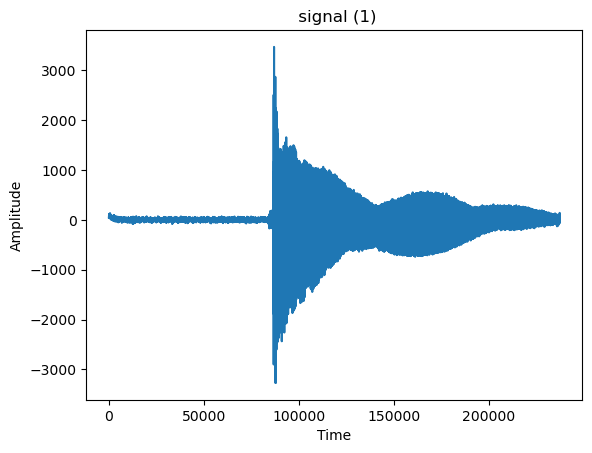

In [199]:
plt.title(f" signal ({file})")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.plot(data_list[n])

In [181]:
fourier = fft(data_list[n])
fourier[0]

(120912+0j)

In [182]:
# Take the real part of half of the fourier output, as the other half is
# symmetric by definition.

hfourier = np.abs(fourier[:len(fourier)//2])

According to Nyquist law, the highest physical frequency which can be represented by its samples without aliasing is simply (Sampling rate)/2

In [183]:
NyquistMaxFreq= sample_rates[n]/2
NyquistMaxFreq

22050.0

Therefore the frequency bins for our fft of lenght N must be : 

Nyquist/(N)



In [209]:
N= len(hfourier)
freq_bins=NyquistMaxFreq/N
freq_bins

0.18563106142241378

In [210]:
frequencies= np.arange(0, NyquistMax, freq_bins)

In [232]:
# N is the lenght of the output of the FFT
# Sample_rate from the original signal

def get_freq_bins(N,sample_rate):
    NyquistMaxFreq= sample_rate/2
    freq_bins=NyquistMaxFreq/N
    frequencies= np.arange(0, NyquistMaxFreq, freq_bins)
    return frequencies

In [217]:
frequencies= get_freq_bins(N, sample_rates[n])

44100
0.18563106142241378


Normalize the spectrum with signal length. 

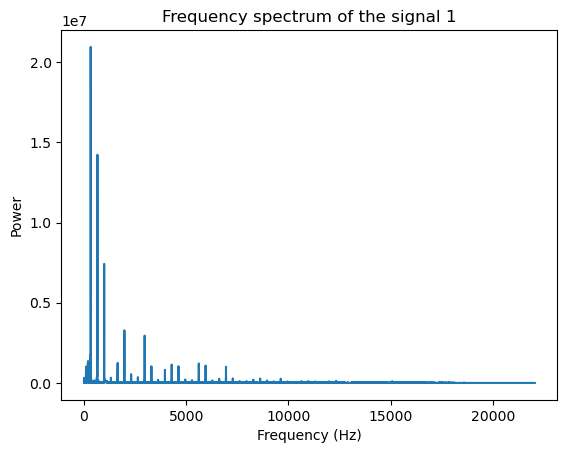

In [218]:
plt.title(f"Frequency spectrum of the signal {file}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.plot(frequencies,  hfourier)

In [219]:
peak_freq = frequencies[np.argmax(hfourier)]
print(peak_freq)

329.68076508620686


In [220]:
ind = np.argpartition(hfourier, -5)[-5:]
for i in ind:
    print(frequencies[i])

330.2376582704741
659.1758991109914
330.0520272090517
329.4951340247845
329.68076508620686


# Algorithm with accuracy on Cents

Note on the coomplexity: the optimal algorithm for doing this would be by using binary search but as the size of our ranges is small, the computation time remains relativeley the same even for the worst case.  

Hence we do a brute force search for a frequency range:

In [105]:
def note_for_frequency(x):
    for note, (lower, _, upper) in ranges.items():
        if lower <= x <= upper:
            return note
    return None   

In [116]:
note_for_frequency(392.1471097089355)

In [157]:
def cents(note, frequency):
    cent= notes[note][1]
    f=frequency-notes[note][0]
    res = (round(f/cent,2))
    return f"{res:+}"
    

In [158]:
cents("G3",196.07355485446774)

'+0.49'

In [231]:
    
def find_note(peak_freq):
    note = note_for_frequency(peak_freq)
    
    if(note):
        print(f"peak freq return: {peak_freq}")
        return note + " "+ cents(note,peak_freq)
    else:
        if(peak_freq<146):
            return find_note(peak_freq*2)
        else:
            return find_note(peak_freq/2)

In [224]:
print(find_note(392.1471097089355))

peak freq: 196.07355485446774
G3 +0.49


In [225]:
note_for_frequency(392.1471097089355/2)

'G3'

In [233]:
def note_from_file(file):
    
    sample_rate, data= wav.read(file)
    
    fourier = fft(data)
    
    N= len(fourier)
    
    hfourier = np.abs(fourier[:N//2])
    frequencies= get_freq_bins(N//2,sample_rate)
    
    peak_freq = frequencies[np.argmax(hfourier)]
    print(f"initial peak: {peak_freq}")
    note = find_note(peak_freq)
    
    return note

In [234]:
note_from_file("string_1.wav")

initial peak: 329.68076508620686
peak freq return: 329.68076508620686


'E1 +0.34'

In [240]:
for i in range(1,4):
    print(note_from_file(f"string_{i}.wav"))
    print("______________________________________")

initial peak: 329.68076508620686
peak freq return: 329.68076508620686
E1 +0.34
______________________________________
initial peak: 392.1471097089355
peak freq return: 196.07355485446774
G3 +0.49
______________________________________
initial peak: 110.12232194557035
peak freq return: 110.12232194557035
A5 +1.53
______________________________________
